In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary


In [11]:

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
latent_dim = 2

# Data loader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
                # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_fc1 = nn.Linear(64 * 7 * 7, 128)
        self.enc_fc21 = nn.Linear(128, latent_dim)  # mean
        self.enc_fc22 = nn.Linear(128, latent_dim)  # log-variance

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, 64 * 7 * 7)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
    
    def encode(self, x):
        h1 = torch.relu(self.enc_conv1(x))
        h1 = self.enc_pool1(h1)
        h2 = torch.relu(self.enc_conv2(h1))
        h2 = self.enc_pool2(h2)
        h2 = h2.view(-1, 64 * 7 * 7)
        h3 = torch.relu(self.enc_fc1(h2))
        return self.enc_fc21(h3), self.enc_fc22(h3)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h4 = torch.relu(self.dec_fc1(z))
        h5 = torch.relu(self.dec_fc2(h4))
        h5 = h5.view(-1, 64, 7, 7)
        h6 = self.dec_upsample1(h5)
        h7 = torch.relu(self.dec_conv1(h6))
        h8 = self.dec_upsample2(h7)
        return torch.sigmoid(self.dec_conv2(h8))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [12]:
# Training
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [13]:
summary(model, (1, 28, 28))  # input shape: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                    [-1, 2]             258
            Linear-7                    [-1, 2]             258
            Linear-8                  [-1, 128]             384
            Linear-9                 [-1, 3136]         404,544
         Upsample-10           [-1, 64, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]          18,464
         Upsample-12           [-1, 32, 28, 28]               0
           Conv2d-13            [-1, 1, 28, 28]             289
Total params: 844,549
Trainable params:

In [ ]:

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(torch.device('cpu'))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item() / len(data)}')
    
    print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(train_loader.dataset)}')


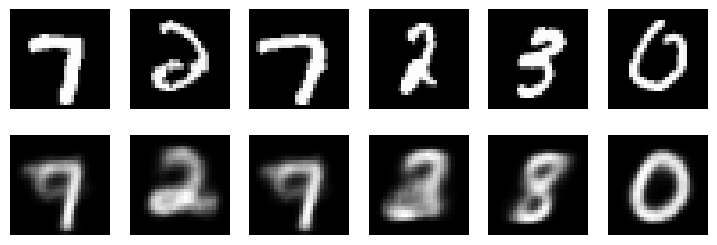

In [7]:
# Visualization
def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(torch.device('cpu'))
        recon, _, _ = model(data)
        
        plt.figure(figsize=(9, 3))
        for i in range(6):
            plt.subplot(2, 6, i + 1)
            plt.imshow(data[i][0], cmap='gray')
            plt.axis('off')
            plt.subplot(2, 6, i + 7)
            plt.imshow(recon[i][0], cmap='gray')
            plt.axis('off')
        plt.show()

def visualize_latent_space(model, data):
    model.eval()
    with torch.no_grad():
        z_list = []
        y_list = []
        for batch_idx, (data, labels) in enumerate(data):
            data = data.to(torch.device('cpu'))
            mu, logvar = model.encode(data)
            z = model.reparameterize(mu, logvar)
            z_list.append(z)
            y_list.append(labels)
        
        z = torch.cat(z_list)
        y = torch.cat(y_list)
        
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.5)
        plt.colorbar(scatter, spacing='proportional')
        plt.show()

# Visualize some reconstructions
examples = enumerate(train_loader)
batch_idx, (example_data, _) = next(examples)
visualize_reconstruction(model, example_data)




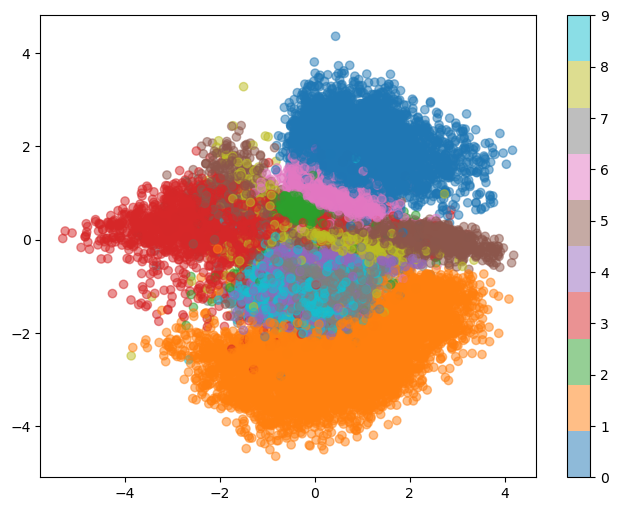

In [8]:
# Visualize the latent space
visualize_latent_space(model, train_loader)